# Q-Learning - First steps

First steps to implement a DQN agent

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any
from collections import deque
import random

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1 First own DQN test

In [ ]:
torch.cuda.is_available()

True

Episode 0 - Reward: 964 - Epsilon: 1.00
Episode 1 - Reward: 828 - Epsilon: 0.99
Episode 2 - Reward: 584 - Epsilon: 0.99
Episode 3 - Reward: 476 - Epsilon: 0.99
Episode 4 - Reward: 840 - Epsilon: 0.98
Episode 5 - Reward: 1336 - Epsilon: 0.98
Episode 6 - Reward: 1308 - Epsilon: 0.97
Episode 7 - Reward: 1560 - Epsilon: 0.97
Episode 8 - Reward: 1224 - Epsilon: 0.96
Episode 9 - Reward: 864 - Epsilon: 0.96
Episode 10 - Reward: 456 - Epsilon: 0.95
Episode 11 - Reward: 440 - Epsilon: 0.95
Episode 12 - Reward: 556 - Epsilon: 0.94
Episode 13 - Reward: 1936 - Epsilon: 0.94
Episode 14 - Reward: 680 - Epsilon: 0.93
Episode 15 - Reward: 1752 - Epsilon: 0.93
Episode 16 - Reward: 588 - Epsilon: 0.92
Episode 17 - Reward: 1352 - Epsilon: 0.92
Episode 18 - Reward: 688 - Epsilon: 0.91
Episode 19 - Reward: 1128 - Epsilon: 0.91
Episode 20 - Reward: 860 - Epsilon: 0.90
Episode 21 - Reward: 420 - Epsilon: 0.90
Episode 22 - Reward: 924 - Epsilon: 0.90
Episode 23 - Reward: 1556 - Epsilon: 0.89
Episode 24 - Rewa

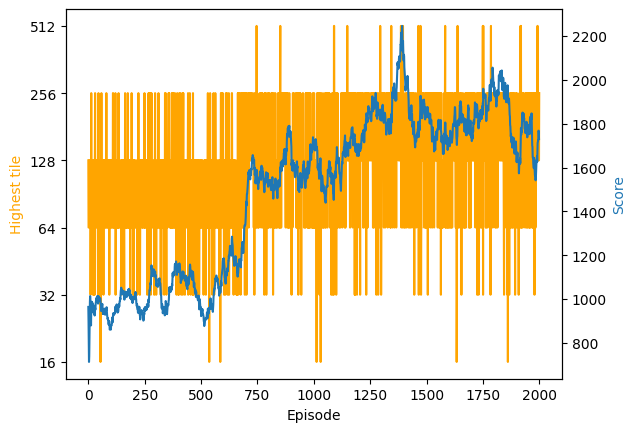

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], action_space: gym.spaces.Space,  device) -> None:
        super(DQN, self).__init__()
        self.device = device
        self.action_space = action_space
        if action_space.shape is None or len(action_space.shape) != 1:
            raise RuntimeError("The action space must provide an 1D shape as property")
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(grid_shape[0]*grid_shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, action_space.shape[0])
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    def predict_action(self, x: np.ndarray, mask: np.ndarray|None = None) -> tuple[Action, np.ndarray]:
        """ 
        Predict the action according to the probabilities in the grid

        Args:
            x (np.ndarray): The current state encoded as numpy objet (e.g. (4,4) game grid)
            mask (np.ndarray|None): If not None, the mask should be an 1D array of length 4 of zeros and ones.
                The model will only predict actions masked to have an 1. This can be used to filter invalid actions before
                sending the state to the model.

        Returns:
            action (Action): Predicted action using the probabilities provided by the model
            probs (np.ndarray): Probs
        
        """
        t = torch.from_numpy(x[None, :]).float().to(self.device)
        with torch.no_grad():
            q_values = self.forward(t)
        probs = nn.functional.softmax(q_values, dim=1).detach().cpu().numpy()
        return self.action_space.sample(mask=mask, probability=probs[0]), probs


class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.001, 
                gamma: float = 0.99,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory: deque[tuple[np.ndarray, Action, int|float, np.ndarray, bool]] = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 64

    def step(self) -> bool:
        action = self.predict()
        state = self.env.game.grid
        next_state, reward, done, truncated, info = env.step(action)
        self.memory.append((state, action, float(reward), next_state, done or truncated))
        return done or truncated

    def predict(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        return self.model.predict_action(self.env.game.grid_stacks, mask=mask)[0]
    
    def predict_greedy(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.env.game.grid_stacks, mask=mask)[0]
    
    def get_probs(self) -> np.ndarray:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.env.game.grid_stacks, mask=mask)[1]

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        actions = torch.from_numpy(np.array([a.value for a in actions])).to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).float().to(self.device)

        q_values = self.model.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model.forward(next_states).max(1, keepdim=True)[0]
        targets: torch.Tensor = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env)
scores = []
highest_tiles = []
move_counts = []

for episode in range(2000):
    obs, info = env.reset()
    done = False

    while not done:
        done = agent.step()
        agent.train_step()

    print(f"Episode {episode} - Reward: {env.game.score} - Epsilon: {agent.epsilon:.2f}")
    agent.decay_epsilon()

    scores.append(env.game.score)
    highest_tiles.append(env.game.highest_tile)
    move_counts.append(env.game.move_count)

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(highest_tiles), label="Highest tile", c="orange")
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores))], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
print(env.game)
for i in range(10):
    env.reset()
print(env.game)
print(env.game.get_moves())
print(agent.get_probs())

<2048 Game (Ended): score 200; 33 moves lead to 32 as highest tile>
[[16  4  2]
 [ 8 32  4]
 [ 4  8  2]]
<2048 Game: score 0; 0 moves lead to 2 as highest tile>
[[0 0 0]
 [0 0 0]
 [2 2 0]]
[<Action.UP: 0>, <Action.RIGHT: 3>, <Action.LEFT: 2>]
[[0.35572153 0.21018243 0.1505147  0.28358138]]


### 2nd DQN Agent with convolution

In [48]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], action_space: gym.spaces.Space,  device) -> None:
        super(DQN, self).__init__()
        self.device = device
        self.action_space = action_space
        if action_space.shape is None or len(action_space.shape) != 1:
            raise RuntimeError("The action space must provide an 1D shape as property")
        self.grid_size = grid_shape[0]*grid_shape[1]

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,grid_shape[1]), padding="valid")
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(grid_shape[0], 1), padding="valid")
        self.conv1.to(self.device)
        self.conv2.to(self.device)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.grid_size+grid_shape[0]+grid_shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, action_space.shape[0])
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        c1 = self.conv1.forward(x).flatten(start_dim=-2)
        c2 = self.conv2.forward(x).flatten(start_dim=-2)
        x = x.flatten(start_dim=-2)
        c = torch.cat((c1, c2, x), dim=2)
        return self.net(c)
    
    def predict_action(self, x: np.ndarray, mask: np.ndarray|None = None) -> tuple[Action, np.ndarray]:
        """ 
        Predict the action according to the probabilities in the grid

        Args:
            x (np.ndarray): The current state encoded as numpy objet (e.g. (4,4) game grid)
            mask (np.ndarray|None): If not None, the mask should be an 1D array of length 4 of zeros and ones.
                The model will only predict actions masked to have an 1. This can be used to filter invalid actions before
                sending the state to the model.

        Returns:
            action (Action): Predicted action using the probabilities provided by the model
            probs (np.ndarray): Probs
        
        """
        t = torch.from_numpy(x).float().to(self.device)
        while len(t.shape) < 4:
            t = t.unsqueeze(0)
        with torch.no_grad():
            q_values = self.forward(t)
        probs = nn.functional.softmax(q_values, dim=1).detach().cpu().numpy()
        return self.action_space.sample(mask=mask, probability=probs[0]), probs


class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.001, 
                gamma: float = 0.99,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory: deque[tuple[np.ndarray, Action, int|float, np.ndarray, bool]] = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 64

    def step(self) -> bool:
        action = self.predict()
        state = self.env.game.grid
        next_state, reward, done, truncated, info = env.step(action)
        self.memory.append((state[None, :, :], action, float(reward), next_state[None, :, :], done or truncated))
        return done or truncated

    def predict(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        return self.model.predict_action(self.env.game.grid, mask=mask)[0]
    
    def predict_greedy(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.env.game.grid, mask=mask)[0]
    
    def get_probs(self) -> np.ndarray:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.env.game.grid, mask=mask)[1]

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        actions = torch.from_numpy(np.array([a.value for a in actions])).to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).float().to(self.device)

        q_values = self.model.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model.forward(next_states).max(1, keepdim=True)[0]
        targets: torch.Tensor = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env)
scores = []
highest_tiles = []
move_counts = []

for episode in range(1000):
    obs, info = env.reset()
    done = False

    while not done:
        done = agent.step()
        agent.train_step()

    print(f"Episode {episode} - Reward: {env.game.score} - Epsilon: {agent.epsilon:.2f}")
    agent.decay_epsilon()

    scores.append(env.game.score)
    highest_tiles.append(env.game.highest_tile)
    move_counts.append(env.game.move_count)

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(highest_tiles), label="Highest tile", c="orange")
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores))], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

Episode 0 - Reward: 532 - Epsilon: 1.00
Episode 1 - Reward: 488 - Epsilon: 0.99
Episode 2 - Reward: 1256 - Epsilon: 0.99
Episode 3 - Reward: 1128 - Epsilon: 0.99
Episode 4 - Reward: 260 - Epsilon: 0.98
Episode 5 - Reward: 640 - Epsilon: 0.98
Episode 6 - Reward: 1128 - Epsilon: 0.97
Episode 7 - Reward: 1556 - Epsilon: 0.97
Episode 8 - Reward: 520 - Epsilon: 0.96
Episode 9 - Reward: 572 - Epsilon: 0.96
Episode 10 - Reward: 564 - Epsilon: 0.95
Episode 11 - Reward: 696 - Epsilon: 0.95
Episode 12 - Reward: 1932 - Epsilon: 0.94
Episode 13 - Reward: 1168 - Epsilon: 0.94
Episode 14 - Reward: 932 - Epsilon: 0.93
Episode 15 - Reward: 1288 - Epsilon: 0.93
Episode 16 - Reward: 772 - Epsilon: 0.92
Episode 17 - Reward: 780 - Epsilon: 0.92
Episode 18 - Reward: 1292 - Epsilon: 0.91
Episode 19 - Reward: 1008 - Epsilon: 0.91
Episode 20 - Reward: 1256 - Epsilon: 0.90
Episode 21 - Reward: 1028 - Epsilon: 0.90
Episode 22 - Reward: 1256 - Epsilon: 0.90
Episode 23 - Reward: 1252 - Epsilon: 0.89
Episode 24 - 

KeyboardInterrupt: 

In [45]:
agent.model.predict_action(env.game.grid_stacks[:, None, :, :])

torch.Size([16, 4])


(<Action.LEFT: 2>,
 array([[0.30099797, 0.23109561, 0.23295602, 0.23495042],
        [0.27487248, 0.24807897, 0.24777281, 0.22927569],
        [0.30725518, 0.23259352, 0.21205468, 0.24809669],
        [0.30509076, 0.22870193, 0.22065769, 0.24554954],
        [0.31019405, 0.22798494, 0.21671633, 0.2451047 ],
        [0.30624634, 0.2238862 , 0.21766193, 0.25220555],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922],
        [0.30755088, 0.22858822, 0.21972169, 0.24413922]], dtype=float32))

In [ ]:
t = torch.from_numpy(env.game.grid[None, :]).float()
t.shape

torch.Size([1, 4, 4])

In [ ]:
c1 = agent.model.conv1.forward(t)
c2 = agent.model.conv2.forward(t)
c = torch.cat((c1.flatten(), c2.flatten(), t.flatten()), dim=0)
print(c1.shape, c2.shape, c.shape)

torch.Size([1, 4, 1]) torch.Size([1, 1, 4]) torch.Size([24])
